## aggregate

> This module aggregates the downloaded data into the respective output dataframes.

In [1]:
#| default_exp aggregate


In [2]:
#| hide
from nbdev.showdoc import *

We prototyped the code in this module using a Jupyter notebook. The notebook is available in `notes/prototypes/learning_aggregations_w_michelle_20250328.ipynb`. The code in this module is a cleaned-up version of the code in that notebook. The notebook contains additional comments and explanations of the code, which may be helpful for understanding the code in this module.

The basic process is as follows:

1. Load the netCDF data in memory
2. Statistically aggregate the hourly data to daily data per exposure using resample()
3. Write out the data to tiff
4. Read the tiff data back in
5. Read in the shapefile that defines the healthsheds
6. Spatially aggregate the exposure data to the healthsheds
7. Quality check the aggregations
8. Write out final aggregations to tiff

In [3]:
#| export

import tempfile
import rasterio
import hydra
import argparse
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from dataclasses import dataclass, field
from typing import Optional, Tuple
from pyprojroot import here
from hydra import initialize, compose
from omegaconf import OmegaConf, DictConfig
from tqdm import tqdm
from math import ceil, floor
from rasterstats.io import Raster
from rasterstats.utils import boxify_points, rasterize_geom

try: from era5_sandbox.core import GoogleDriver, _get_callable, describe
except: from core import GoogleDriver, _get_callable, describe

In [4]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

We're going to write a function that aggregates the data for a single exposure from a file. This file should be the single month data we got from the previous step in the pipeline.

In [5]:
eg_file = here() / "data/input/madagascar_2010_1.nc"

In [6]:
#| export 

def resample_netcdf(
        fpath: str, # Path to the netCDF file.
        resample: str = "1D", # Resampling frequency (e.g., '1H', '1D')
        agg_func: callable = np.mean, # Aggregation function (e.g., np.mean, np.sum).
        time_dim: str = "valid_time", # Name of the time dimension in the dataset.
        **xr_open_kwargs  # keywords for python's xarray module
    ) -> xr.Dataset:   
    """
    Resample a netCDF file to a specified frequency and aggregation method.
    
    Args:
        fpath (str): Path to the netCDF file.
        resample (str): Resampling frequency (e.g., '1H', '1D').
        agg_func (callable): Aggregation function (e.g., np.mean, np.sum).
    
    Returns:
        xarray.Dataset: Resampled dataset.
    """

    ds = xr.open_dataset(fpath, **xr_open_kwargs)

    if callable(agg_func):
        # Use xarray's reduce method with the callable
        return ds.resample({time_dim: resample}).reduce(agg_func)
    else:
        raise TypeError("agg_func must be a callable function like np.mean, np.max, etc.")

In [7]:
resample_netcdf(eg_file)

<xarray.Dataset> Size: 484kB
Dimensions:     (valid_time: 31, latitude: 59, longitude: 33)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
  * valid_time  (valid_time) datetime64[ns] 248B 2010-01-01 ... 2010-01-31
Data variables:
    d2m         (valid_time, latitude, longitude) float32 241kB 297.7 ... 293.1
    t2m         (valid_time, latitude, longitude) float32 241kB 300.9 ... 297.9
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-18T21:53 GRIB to CDM+CF via cfgrib-0.9.1...

I'm going to use a dataclass to represent the tiff data. This will allow us to easily pass around the data and metadata associated with the tiff file. Why? Because I can, lol (I've never used dataclasses and I'm curious about them). ChatGPT thinks this will make the code cleaner and easier to read.

In [8]:
#| export

@dataclass
class RasterFile:
    path: str
    band: int # note that this is 1-indexed
    data: Optional[np.ndarray] = field(default=None, init=False)
    transform: Optional[rasterio.Affine] = field(default=None, init=False)
    crs: Optional[str] = field(default=None, init=False)
    nodata: Optional[float] = field(default=None, init=False)
    bounds: Optional[Tuple[float, float, float, float]] = field(default=None, init=False)

    def load(self):
        """Load raster data and basic metadata."""
        with rasterio.open(self.path) as src:
            self.data = src.read(self.band)  # each day gets one rasterfile
            self.transform = src.transform
            self.crs = src.crs
            self.nodata = src.nodata
            self.bounds = src.bounds
        return self

    def shape(self) -> Optional[Tuple[int, int]]:
        """Return the shape of the raster data."""
        return self.data.shape if self.data is not None else None

    def __str__(self):
        return f"RasterFile(path='{self.path}', shape={self.shape()}, crs='{self.crs}')"

Next, a function to write and read the netCDF to tiff:

In [9]:
#| export

def netcdf_to_tiff(
    ds: xr.Dataset, # The aggregated xarray dataset to convert.    
    band: int,      # The day to rasterise; 1 indexed just like human english
    variable: str, # The variable name to convert.
    crs: str = "EPSG:4326", # Coordinate reference system (default is WGS84).    
    ):

    """
    Convert a netCDF file to a GeoTIFF file.
    
    Args:
        fpath (str): Path to the netCDF file.
        output_path (str): Path to save the output GeoTIFF file.
        variable_name (str): Name of the variable to convert.
        time_index (int): Index of the time dimension to extract.
    """

    with tempfile.TemporaryDirectory() as tmpdirname:

        # Select the variable and time index
        variable = ds[variable]
        ds_ = variable.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
        ds_ = ds_.rio.write_crs(crs)
        # Save as GeoTIFF
        ds_.rio.to_raster(f"{tmpdirname}/output.tif")
        # Load the raster file
        raster_file = RasterFile(path=f"{tmpdirname}/output.tif", band=band).load()

    return raster_file

Now to test it:

In [10]:
resampled_nc = resample_netcdf(eg_file)
print(resampled_nc)
resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc,
    band=28,
    variable="t2m",
    crs="EPSG:4326"
)

<xarray.Dataset> Size: 484kB
Dimensions:     (valid_time: 31, latitude: 59, longitude: 33)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 472B -11.6 -11.85 -12.1 ... -25.85 -26.1
  * longitude   (longitude) float64 264B 42.7 42.95 43.2 ... 50.2 50.45 50.7
  * valid_time  (valid_time) datetime64[ns] 248B 2010-01-01 ... 2010-01-31
Data variables:
    d2m         (valid_time, latitude, longitude) float32 241kB 297.7 ... 293.1
    t2m         (valid_time, latitude, longitude) float32 241kB 300.9 ... 297.9
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-18T21:53 GRIB to CDM+CF via cfgrib-0.9.1...


In [11]:
resampled_tiff.data.shape, resampled_tiff.transform, resampled_tiff.crs, resampled_tiff.bounds

((59, 33),
 Affine(0.25, 0.0, 42.575,
        0.0, -0.25000000000000006, -11.475),
 CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 BoundingBox(left=42.575, bottom=-26.225, right=50.825, top=-11.475))

Super cool! The tiff file is created and the data is read back in correctly. Now we can move on to the next step, which is to aggregate the data by healthshed.

## Polygon to Raster Cells

This function was initially shared from a previous NSAPH aggregation pipeline [here](https://github.com/NSAPH-Data-Processing/air_pollution__aqdh/blob/2a8109075fe7a8fbf7c435cc34ffa97b63f5e133/utils/faster_zonal_stats.py#L17). To better understand this, here is a ChatGPT explanation of the code:

> This function, `polygon_to_raster_cells`, is doing a crucial first step in spatial alignment: it determines which raster cells are “touched” by each polygon geometry (e.g., administrative areas, watersheds, etc.).    
Essentially, this function helps figure out which pixels from a raster image fall inside each polygon (like a district, region, or shape). It does this by looking at each polygon one by one, zooming in on just the part of the raster that overlaps with that shape, and marking the pixels that are inside. This is kind of like placing a cookie cutter (the polygon) on a pixelated map (the raster) and seeing which pixels get cut.  
The result is a list where each item tells you the pixel locations that match a specific polygon. You can then use those pixel locations to pull out data from the raster, like temperatures or rainfall, and calculate statistics (like the average) for each shape. This is a key step when you want to summarize raster data within specific regions, like figuring out the average temperature in each county or how much vegetation is in each park.

In [12]:
#| export 

def polygon_to_raster_cells(
    vectors,
    raster,
    nodata=None,
    affine=None,
    all_touched=False,
    verbose=False,
    **kwargs,
):
    """Returns an index map for each vector geometry to indices in the raster source.

    Parameters
    ----------
    vectors: list of geometries

    raster: ndarray

    nodata: float

    affine: Affine instance

    all_touched: bool, optional
        Whether to include every raster cell touched by a geometry, or only
        those having a center point within the polygon.
        defaults to `False`

    Returns
    -------
    dict
        A dictionary mapping vector the ids of geometries to locations (indices) in the raster source.
    """

    cell_map = []

    with Raster(raster, affine, nodata) as rast:
        # used later to crop raster and find start row and col
        min_lon, dlon = affine.c, affine.a
        max_lat, dlat = affine.f, -affine.e
        H, W = rast.shape

        for geom in tqdm(vectors, disable=(not verbose)):
            if "Point" in geom.geom_type:
                geom = boxify_points(geom, rast)

            # find geometry bounds to crop raster
            # the raster and geometry must be in the same lon/lat coordinate system
            start_row = max(0, min(H - 1, floor((max_lat - geom.bounds[3]) / dlat)))
            start_col = min(W - 1, max(0, floor((geom.bounds[0] - min_lon) / dlon)))
            end_col = max(0, min(W - 1, ceil((geom.bounds[2] - min_lon) / dlon)))
            end_row = min(H - 1, max(0, ceil((max_lat - geom.bounds[1]) / dlat)))
            geom_bounds = (
                min_lon + dlon * start_col,  # left
                max_lat - dlat * end_row - 1e-12,  # bottom
                min_lon + dlon * end_col + 1e-12,  # right
                max_lat - dlat * start_row,  # top
            )

            # crop raster to area of interest and rasterize
            fsrc = rast.read(bounds=geom_bounds)
            rv_array = rasterize_geom(geom, like=fsrc, all_touched=all_touched)
            indices = np.nonzero(rv_array)

            if len(indices[0]) > 0:
                indices = (indices[0] + start_row, indices[1] + start_col)
                assert 0 <= indices[0].min() < rast.shape[0]
                assert 0 <= indices[1].min() < rast.shape[1]
            else:
                pass  # stop here for debug

            cell_map.append(indices)

        return cell_map

To use this, we must define the polygon and raster data. The polygon data is the healthshed shapefile, and the raster data is the tiff file we created earlier. We can use the `GoogleDriver` class we defined in `core` to read in the shapefile.

In [13]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()
healthsheds = driver.read_healthsheds("healthsheds2022.zip")

In [14]:
res_poly2cell=polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=resampled_tiff.data, # the raster data above
    nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
    affine=resampled_tiff.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

  0%|          | 0/2766 [00:00<?, ?it/s]/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|██████████| 2766/2766 [00:01<00:00, 1587.94it/s]


The data below maps which grid entries fall into each of the regions in the shapefile (e.g. which pixel is in which state)

In [15]:
res_poly2cell[:5]

[(array([37, 38, 38]), array([22, 21, 22])),
 (array([30]), array([21])),
 (array([38, 38]), array([22, 23])),
 (array([40, 41]), array([18, 18])),
 (array([30]), array([20]))]

Last but not least, we aggregate these data to the healthshed level. We can use the `rasterstats` package to do this.

In [16]:
#| export

def aggregate_to_healthsheds(
    res_poly2cell: list, # the result of polygon_to_raster_cells    
    raster: RasterFile, # the raster data
    shapes: gpd.GeoDataFrame, # the shapes of the health sheds
    names_column: str = "fs_uid", # the unique identifier column name of the health sheds
    aggregation_func: callable = np.nanmean, # the aggregation function
    aggregation_name: str = "mean" # the name of the aggregation function
    ) -> gpd.GeoDataFrame:
    """
    Aggregate the raster data to the health sheds.
    """

    stats = []

    for indices in res_poly2cell:
        if len(indices[0]) == 0:
            # no cells found for this polygon
            stats.append(np.nan)
        else:
            cells = raster.data[indices]
            if sum(~np.isnan(cells)) == 0:
                # no valid cells found for this polygon
                stats.append(np.nan)
                continue
            else:
                # compute MEAN of valid cells
                # but this stat can be ANYTHING
                stats.append(aggregation_func(cells))

    # clean up the result into a dataframe
    stats = pd.Series(stats)
    shapes[aggregation_name] = stats
    df = pd.DataFrame(
            {"healthshed": shapes[names_column], aggregation_name: stats}
        )
    gdf = gpd.GeoDataFrame(df, geometry=shapes.geometry.values, crs=shapes.crs)
    return gdf


And now we apply it:

In [17]:
result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fs_uid",
    aggregation_func=np.nanmean,
    aggregation_name="mean_temperature"
)
result.head()

,healthshed,mean_temperature,geometry
0,A0YU5ksfXZS,300.806244,"POLYGON ((48.21537 -20.95662, 48.21593 -20.956..."
1,A1SY9AiVPYF,295.823456,"POLYGON ((47.85923 -19.09954, 47.8601 -19.0998..."
2,A38WhL0NPsX,301.165192,"POLYGON ((48.35588 -21.05353, 48.35801 -21.057..."
3,A6fVNQgqqJg,296.830078,"POLYGON ((47.18552 -21.70624, 47.19275 -21.711..."
4,A77QRkmKUul,294.940887,"POLYGON ((47.73249 -19.15372, 47.73267 -19.153..."


And plot for QA:

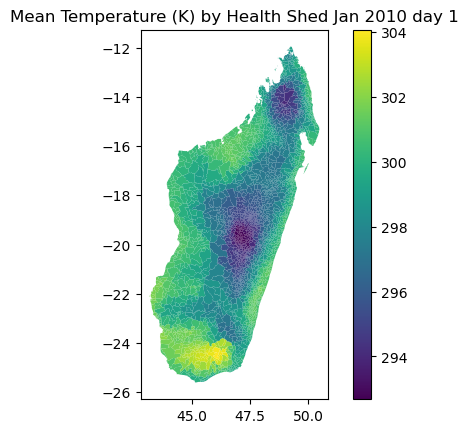

In [18]:
result.plot(column="mean_temperature", legend=True)
plt.title("Mean Temperature (K) by Health Shed Jan 2010 day 1")
plt.show()

That looks great! The data is aggregated to the healthshed level, and we can see the differences in exposure across the healthsheds. We can also see that the data is not uniform across the healthsheds, which is what we expect.

## Tests and Main

Now we can wrap this up in a main function that will simply take in the input file and generate this output. We can also add some tests to make sure the data is aggregated correctly; tests will run automatically in this notebook.

/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/lib/python3.11/site-packages/xarray/namedarray/core.py:919: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/n/home03/ttapera/.conda/envs/era5_sandbox/li

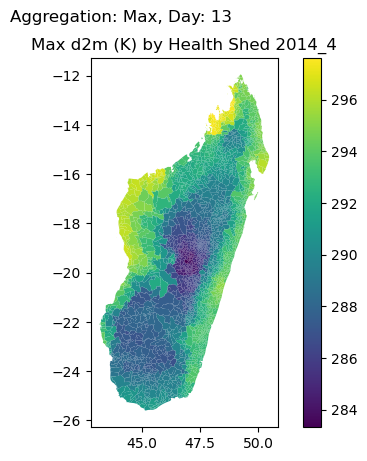

100%|██████████| 2766/2766 [00:01<00:00, 1648.49it/s]


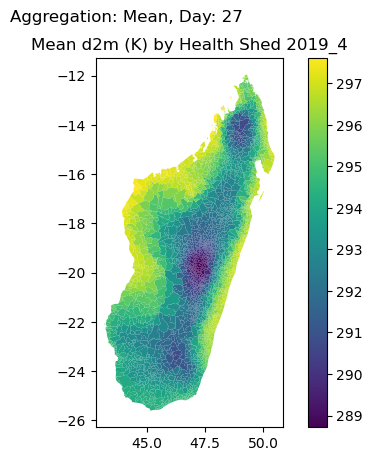

100%|██████████| 2766/2766 [00:01<00:00, 1638.56it/s]


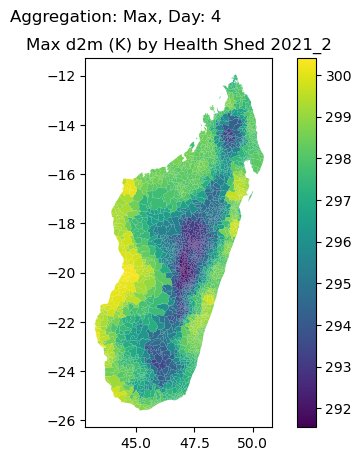

100%|██████████| 2766/2766 [00:01<00:00, 1661.64it/s]


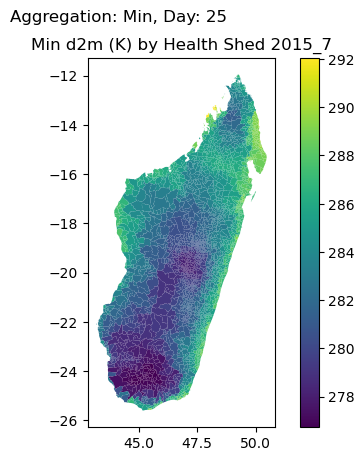

100%|██████████| 2766/2766 [00:01<00:00, 1655.63it/s]


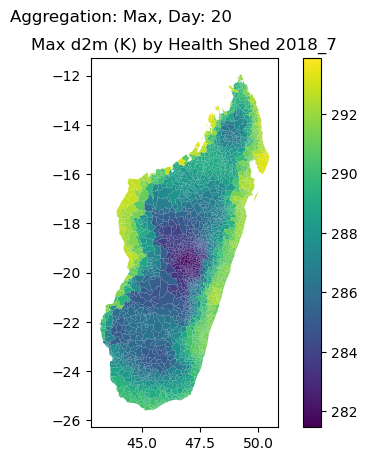

100%|██████████| 2766/2766 [00:02<00:00, 1151.51it/s]


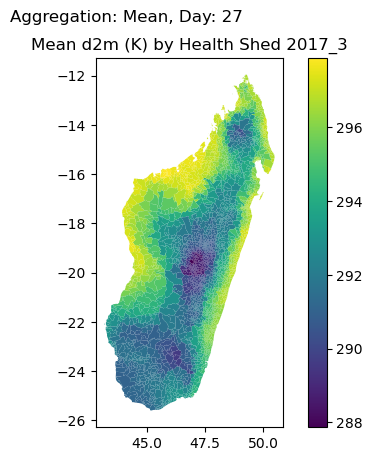

100%|██████████| 2766/2766 [00:01<00:00, 1663.42it/s]


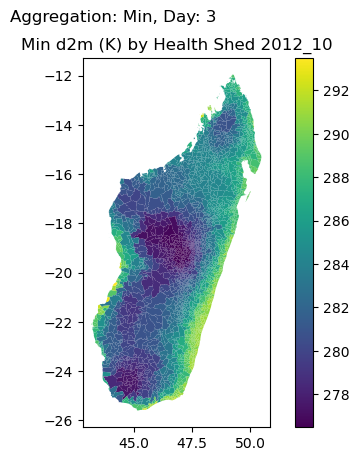

100%|██████████| 2766/2766 [00:01<00:00, 1667.95it/s]


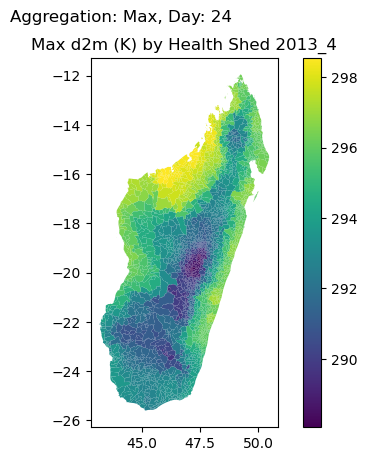

6.18 s ± 1.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit

import random

variables = ["t2m", "d2m"]
years = ["20{:02d}".format(m) for m in range(9, 24)]
months = [str(m) for m in range(1, 13)]
aggregations = [
    ("Mean", np.nanmean),
    ("Max", np.nanmax),
    ("Min", np.nanmin)
]

exposure_variable = random.choice(variables)
year = random.choice(years)
month = random.choice(months)
aggregation_str, agg_func = random.choice(aggregations)
input_file = here() / "data/input/{}_{}.nc".format(year, month)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
drive = driver.get_drive()
healthsheds = driver.read_healthsheds(cfg.GOOGLE_DRIVE_AUTH_JSON.healthsheds_id)


resampled_nc_file = resample_netcdf(input_file, agg_func=agg_func)
days = len(resampled_nc_file.valid_time.values)
day = random.choice(range(1, days + 1))

resampled_tiff = netcdf_to_tiff(
    ds=resampled_nc_file,
    band=day, # the day we're aggregating
    variable=exposure_variable,
    crs="EPSG:4326"
)

res_poly2cell=polygon_to_raster_cells(
    vectors = healthsheds.geometry.values, # the geometries of the shapefile of the regions
    raster=resampled_tiff.data, # the raster data above
    nodata=resampled_tiff.nodata, # any intersections with no data, may have to be np.nan
    affine=resampled_tiff.transform, # some math thing need to revise
    all_touched=True, 
    verbose=True
)

result = aggregate_to_healthsheds(
    res_poly2cell=res_poly2cell,
    raster=resampled_tiff,
    shapes=healthsheds,
    names_column="fs_uid",
    aggregation_func=agg_func,
    aggregation_name=exposure_variable
)

result.plot(column=exposure_variable, legend=True)
plt.title("{} {} (K) by Health Shed {}".format(aggregation_str, exposure_variable, input_file.stem))
plt.suptitle("Aggregation: {}, Day: {}".format(aggregation_str, str(day)))
plt.show()

3.2 seconds per aggregation is pretty cool!

In [20]:

result.to_parquet(here() / "data/testing/test_aggregation.parquet")

For QA, we should come up with the following:

- [x] A way to list NAs in the data
- [ ] A way to visualize the data temporally
- [ ] A function to convert K to celsius

We noticed that there are some NAs in the plots. After some investigation, we have the following conclusions:

- The NetCDF files from the Climate Data Store store missing values directly as NaN, not through _FillValue.
- In R (terra), basic summaries only show non-missing values unless missingness is explicitly checked.
- In Python (xarray), real NaN values are preserved during dataset loading.
- During aggregation, if a healthshed overlaps areas containing only NaN values, functions like np.nanmean correctly return NA.
- Therefore, the NAs seen in aggregated data are real missing climate data in certain regions, not a loading or processing error.

Processing 2009_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2009_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2010_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2010_8.nc...
Processing 2010_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2011_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2012_10.nc...
Processing 2012_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2012_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2013_4.nc...
Processing 2013_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2013_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2014_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2015_7.nc...
Processing 2015_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2015_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2016_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2017_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2018_7.nc...
Processing 2018_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2018_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2019_4.nc...
Processing 2019_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2019_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2020_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2021_2.nc...
Processing 2021_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2021_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2022_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing 2023_10.nc...
Processing 2023_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2023_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing 2024_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2009_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing madagascar_2010_1.nc...
Processing madagascar_2010_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2010_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2011_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2012_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2013_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2014_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2015_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2016_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2017_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2018_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2019_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2020_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2021_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2022_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing madagascar_2023_10.nc...
Processing madagascar_2023_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2023_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing madagascar_2024_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2009_12.nc...
Processing nepal_2009_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2009_6.nc...
Processing nepal_2009_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2009_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2010_1.nc...
Processing nepal_2010_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2010_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2011_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2011_10.nc...
Processing nepal_2011_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2011_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2011_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2011_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2011_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2011_5.nc...
Processing nepal_2011_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2011_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2011_8.nc...
Processing nepal_2011_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2012_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2012_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2012_11.nc...
Processing nepal_2012_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2012_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2012_3.nc...
Processing nepal_2012_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2012_5.nc...
Processing nepal_2012_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2012_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2012_8.nc...
Processing nepal_2012_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2013_2.nc...
Processing nepal_2013_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2013_5.nc...
Processing nepal_2013_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2013_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2014_11.nc...
Processing nepal_2014_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2014_6.nc...
Processing nepal_2014_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2014_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2015_10.nc...
Processing nepal_2015_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2015_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2016_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2017_10.nc...
Processing nepal_2017_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2017_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2018_5.nc...
Processing nepal_2018_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2018_7.nc...
Processing nepal_2018_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2018_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2019_12.nc...
Processing nepal_2019_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2019_5.nc...
Processing nepal_2019_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2019_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2020_4.nc...
Processing nepal_2020_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2020_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2021_2.nc...
Processing nepal_2021_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_8.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2021_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2022_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2022_6.nc...
Processing nepal_2022_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2022_8.nc...
Processing nepal_2022_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2023_1.nc...
Processing nepal_2023_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2023_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2023_12.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2023_2.nc...
Processing nepal_2023_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2023_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2023_5.nc...
Processing nepal_2023_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2023_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2023_8.nc...
Processing nepal_2023_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_1.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_10.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_11.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2024_12.nc...
Processing nepal_2024_2.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_3.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_4.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_5.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_6.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


Processing nepal_2024_7.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The r

Processing nepal_2024_8.nc...
Processing nepal_2024_9.nc...


/tmp/ipykernel_4036383/3178720483.py:30: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  "time_steps": ds.dims.get("valid_time", None),
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


                file  missing_fraction  time_steps
0          2009_1.nc               0.0         744
1         2009_10.nc               0.0         744
2         2009_11.nc               0.0         720
3         2009_12.nc               0.0         744
4          2009_2.nc               0.0         672
..               ...               ...         ...
571  nepal_2024_5.nc               0.0         744
572  nepal_2024_6.nc               0.0         720
573  nepal_2024_7.nc               0.0         744
574  nepal_2024_8.nc               0.0         744
575  nepal_2024_9.nc               0.0         720

[576 rows x 3 columns]


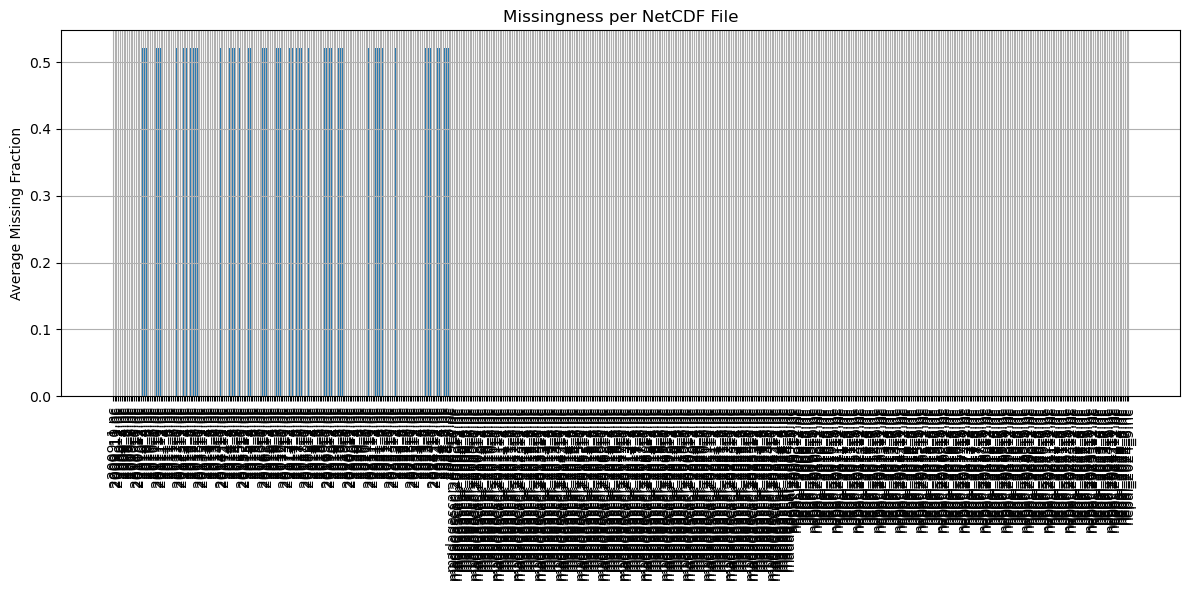

In [21]:
data_dir = here() / "data/input/"
nc_files = sorted(data_dir.glob("*.nc"))
# Storage for missingness summary
missingness_summary = []

# Loop over files
for file in nc_files:
    print(f"Processing {file.name}...")
    
    # Open dataset (no automatic masking)
    ds = xr.open_dataset(file, mask_and_scale=False)
    
    # Assume your variable is named 't2m' (adjust if needed)
    var_name = "t2m"
    
    if var_name not in ds.data_vars:
        print(f"Warning: {var_name} not found in {file.name}. Skipping.")
        continue
    
    # Calculate missing fraction over spatial dimensions
    missing_fraction = ds[var_name].isnull().mean(dim=["latitude", "longitude"])
    
    # Average missingness across time
    overall_missing_fraction = missing_fraction.mean().item()  # single number
    
    # Record results
    missingness_summary.append({
        "file": file.name,
        "missing_fraction": overall_missing_fraction,
        "time_steps": ds.dims.get("valid_time", None),
    })
    
    ds.close()

# Create a DataFrame
missingness_df = pd.DataFrame(missingness_summary)

# Show results
print(missingness_df)

# Plot if you want
plt.figure(figsize=(12,6))
plt.bar(missingness_df["file"], missingness_df["missing_fraction"])
plt.xticks(rotation=90)
plt.ylabel("Average Missing Fraction")
plt.title("Missingness per NetCDF File")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
missingness_df

,file,missing_fraction,time_steps
0,2009_1.nc,0.0,744
1,2009_10.nc,0.0,744
2,2009_11.nc,0.0,720
3,2009_12.nc,0.0,744
4,2009_2.nc,0.0,672
...,...,...,...
571,nepal_2024_5.nc,0.0,744
572,nepal_2024_6.nc,0.0,720
573,nepal_2024_7.nc,0.0,744
574,nepal_2024_8.nc,0.0,744


In [ ]:
#| export

def aggregate_data(
        cfg: DictConfig,
        input_file: str,
        output_file: str,
        exposure_variable: str
    ) -> None:
    '''
    Aggregate raster data day-by-day and store all days as separate columns in a single Parquet file.
    '''

    if cfg.development_mode:
        describe(cfg)
        return None

    geography = cfg['query'].geography[0]
    year = cfg['query']['year']
    month = cfg['query']['month']


    # Load healthsheds
    driver = GoogleDriver(json_key_path=here() / cfg.GOOGLE_DRIVE_AUTH_JSON.path)
    drive = driver.get_drive()
    healthsheds = driver.read_healthsheds(cfg.geographies[geography].healthsheds)

    agg_func = _get_callable(cfg.aggregation.daily.function)

    resampled_nc_file = resample_netcdf(input_file, agg_func=agg_func)
    days = len(resampled_nc_file.valid_time.values)

    # Initialize output DataFrame
    result_df = healthsheds[[cfg.geographies[geography].unique_id, "geometry"]].copy()

    for day in range(1, days + 1):
        print(f"Processing day {day}...")

        resampled_tiff = netcdf_to_tiff(
            ds=resampled_nc_file,
            band=day,
            variable=exposure_variable,
            crs="EPSG:4326"
        )

        result_poly2cell = polygon_to_raster_cells(
            vectors=healthsheds.geometry.values,
            raster=resampled_tiff.data,
            nodata=resampled_tiff.nodata,
            affine=resampled_tiff.transform,
            all_touched=True,
            verbose=True
        )

        res = aggregate_to_healthsheds(
            res_poly2cell=result_poly2cell,
            raster=resampled_tiff,
            shapes=healthsheds,
            names_column=cfg.geographies[geography].unique_id,
            aggregation_func=agg_func,
            aggregation_name=exposure_variable
        )

        day_col = f"day_{day:02d}"
        result_df[day_col] = res[exposure_variable]

    print(f"Saving final monthly parquet file: {output_file}")
    result_df.to_parquet(output_file, compression="snappy")

In [24]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name='config.yaml')

cfg.development_mode = False
cfg.query['year'] = 2010
cfg.query['month'] = 1
cfg.query['geography'] = ["nepal"]
aggregate_data(cfg, here() / "data/input/nepal_2010_1.nc", here() / "data/testing/test_nepal_aggregation.parquet", "t2m")

Processing day 1...


100%|██████████| 777/777 [00:00<00:00, 1181.02it/s]


Processing day 2...


100%|██████████| 777/777 [00:00<00:00, 1214.59it/s]


Processing day 3...


100%|██████████| 777/777 [00:00<00:00, 1217.04it/s]


Processing day 4...


100%|██████████| 777/777 [00:00<00:00, 1201.36it/s]


Processing day 5...


100%|██████████| 777/777 [00:00<00:00, 1220.94it/s]


Processing day 6...


100%|██████████| 777/777 [00:00<00:00, 1224.34it/s]


Processing day 7...


100%|██████████| 777/777 [00:00<00:00, 1216.92it/s]


Processing day 8...


100%|██████████| 777/777 [00:00<00:00, 1217.96it/s]


Processing day 9...


100%|██████████| 777/777 [00:00<00:00, 1217.05it/s]


Processing day 10...


100%|██████████| 777/777 [00:00<00:00, 1222.26it/s]


Processing day 11...


100%|██████████| 777/777 [00:00<00:00, 1223.73it/s]


Processing day 12...


100%|██████████| 777/777 [00:00<00:00, 1224.14it/s]


Processing day 13...


100%|██████████| 777/777 [00:00<00:00, 1219.39it/s]


Processing day 14...


100%|██████████| 777/777 [00:00<00:00, 1197.60it/s]


Processing day 15...


100%|██████████| 777/777 [00:00<00:00, 1220.81it/s]


Processing day 16...


100%|██████████| 777/777 [00:00<00:00, 1212.25it/s]


Processing day 17...


100%|██████████| 777/777 [00:00<00:00, 1206.91it/s]


Processing day 18...


100%|██████████| 777/777 [00:00<00:00, 1217.15it/s]


Processing day 19...


100%|██████████| 777/777 [00:00<00:00, 1218.36it/s]


Processing day 20...


100%|██████████| 777/777 [00:00<00:00, 1215.75it/s]


Processing day 21...


100%|██████████| 777/777 [00:00<00:00, 1215.67it/s]


Processing day 22...


100%|██████████| 777/777 [00:00<00:00, 1226.80it/s]


Processing day 23...


100%|██████████| 777/777 [00:00<00:00, 1215.14it/s]


Processing day 24...


100%|██████████| 777/777 [00:00<00:00, 1230.24it/s]


Processing day 25...


100%|██████████| 777/777 [00:00<00:00, 1209.18it/s]


Processing day 26...


100%|██████████| 777/777 [00:00<00:00, 1210.29it/s]


Processing day 27...


100%|██████████| 777/777 [00:00<00:00, 1184.44it/s]


Processing day 28...


100%|██████████| 777/777 [00:00<00:00, 1215.94it/s]


Processing day 29...


100%|██████████| 777/777 [00:00<00:00, 1213.63it/s]


Processing day 30...


100%|██████████| 777/777 [00:00<00:00, 1224.78it/s]


Processing day 31...


100%|██████████| 777/777 [00:00<00:00, 1220.39it/s]


Saving monthly aggregation to /net/rcstorenfs02/ifs/rc_labs/dominici_lab/lab/data_processing/csph-era5_sandbox/data/testing/test_nepal_aggregation.parquet...


In [25]:
parquet_file = gpd.read_parquet(here() / "data/testing/test_nepal_aggregation.parquet")

In [26]:
parquet_file

,fid,geometry,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,1,"POLYGON ((87.60719 27.37069, 87.60841 27.36969...",280.072113,281.583099,282.059814,281.926941,279.835846,280.716736,282.702209,283.047394,...,281.742584,281.500275,281.983337,281.407806,280.594330,282.429047,282.250610,283.480621,282.061798,282.397675
1,7,"POLYGON ((88.04438 27.4203, 88.04365 27.41925,...",275.028351,278.113098,278.349304,277.230286,275.769409,276.555359,278.746185,278.626740,...,276.077423,276.019012,276.721008,275.993134,274.721924,277.018890,277.272888,277.878784,276.505157,276.708893
2,8,"POLYGON ((88.14528 27.67003, 88.14526 27.66966...",269.947510,273.995087,275.120209,273.587677,272.205811,272.611755,274.713531,274.569977,...,271.886353,271.725464,272.407013,271.105438,270.015991,272.964722,273.519012,273.832581,272.501038,272.679108
3,23,"POLYGON ((88.0766 27.03545, 88.07695 27.03533,...",282.800781,284.428558,283.570312,283.065277,281.793884,283.340668,285.280365,285.067017,...,284.248932,284.070618,284.403931,284.406036,283.503784,284.794373,284.488647,285.265442,284.633575,284.367859
4,24,"POLYGON ((87.76435 26.92431, 87.76435 26.924, ...",284.393799,285.541382,284.819214,284.658447,283.692596,284.934998,286.721252,286.667755,...,286.422363,286.321136,286.429108,286.739502,286.055878,286.900604,286.815247,287.692535,287.092743,286.986694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,768,"POLYGON ((84.22202 27.77631, 84.22261 27.77579...",285.578796,286.000885,285.794281,286.686462,284.835083,285.833405,287.803406,287.372192,...,287.066071,287.493896,286.952271,287.122803,286.670898,288.725037,288.552856,289.165649,289.173859,289.887878
773,769,"POLYGON ((84.2888 27.79734, 84.28906 27.79733,...",285.935028,286.450409,286.249054,286.854889,285.199768,286.204376,288.212219,287.884644,...,287.406586,287.861511,287.169006,287.554718,286.889374,288.922516,288.816254,289.499420,289.383698,290.168152
774,770,"POLYGON ((84.03688 27.78054, 84.03733 27.78037...",285.011871,285.220947,285.393799,286.571228,284.518036,285.259796,287.188629,286.811249,...,286.636993,287.103058,286.909637,286.921631,286.858948,288.543365,288.296814,288.887939,289.200531,289.514191
775,771,"POLYGON ((84.15643 27.73728, 84.15631 27.73716...",285.378784,285.610046,285.698456,286.779541,284.836304,285.562622,287.549988,287.171692,...,286.885986,287.361633,287.157898,287.381683,287.090271,288.807129,288.559692,289.216492,289.458160,289.763000


<Axes: >

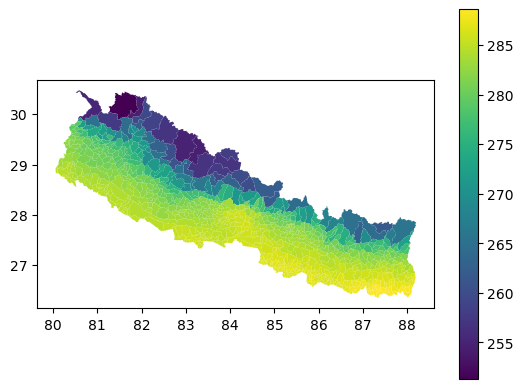

In [28]:
parquet_file.plot(column="day_06", legend=True)

In [ ]:
#| export
@hydra.main(version_base=None, config_path="../../conf", config_name="config")
def main(cfg: DictConfig) -> None:
    # Parse command-line arguments
    input_file = str(snakemake.input[0])  # First input file
    output_file = str(snakemake.output[0])
    aggregation_variable = str(snakemake.params.variable)

    aggregate_data(cfg, input_file=input_file, output_file=output_file, exposure_variable=aggregation_variable)

In [ ]:
#| export
#| eval: false
try: from nbdev.imports import IN_NOTEBOOK
except: IN_NOTEBOOK=False

if __name__ == "__main__" and not IN_NOTEBOOK:
    main()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()